<a href="https://colab.research.google.com/github/sztahodavid/humanaicourse/blob/main/emotion_recognition_speech_wavlm_tsne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ebben a Demo-ban az érzelmek felismerésével ismerkedhetünk meg beszédből. Az adatbázis 38 beszélőt tartalmaz, akik magyar nyelven a "Kovács Katival szeretnék beszélni" szöveget monták be 8 érzelmi állapot imitálásával. Ezen érzelmek a szomorúság, harag, félelem, izgatottság, undor, megelettség, öröm és semeleges. Jelen esetben a jellzőkinyerést egy mély tanuló algoritmussal végezzük.

Az első lépés a *szükséges csomagok* betöltése.

In [1]:
import os
import pandas as pd
import numpy as np
import torchaudio
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.manifold import TSNE

Ezután az elérési utat adjuk meg az adatbázishoz. Az adatbázist szűrjük a fent leírt beszédmintákra (magyar nyelv és 1. feladat). A célcímkéket eltárolkjuk a *labels* változóban.

In [2]:
!wget http://lsa.tmit.bme.hu/files/HungarianEmotionalSentences.zip
!unzip HungarianEmotionalSentences.zip

--2024-11-23 23:42:57--  http://lsa.tmit.bme.hu/files/HungarianEmotionalSentences.zip
Resolving lsa.tmit.bme.hu (lsa.tmit.bme.hu)... 152.66.246.99
Connecting to lsa.tmit.bme.hu (lsa.tmit.bme.hu)|152.66.246.99|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62600577 (60M) [application/x-zip-compressed]
Saving to: ‘HungarianEmotionalSentences.zip’

HungarianEmotionalS 100%[===================>]  59.70M  33.5MB/s    in 1.8s    

2024-11-23 23:43:00 (33.5 MB/s) - ‘HungarianEmotionalSentences.zip’ saved [62600577/62600577]

Archive:  HungarianEmotionalSentences.zip
  inflating: readme.txt              
  inflating: F0001B_hu.wav           
  inflating: F0001D_hu.wav           
  inflating: F0001I_hu.wav           
  inflating: F0001L_hu.wav           
  inflating: F0001M_hu.wav           
  inflating: F0001O_hu.wav           
  inflating: F0001S_hu.wav           
  inflating: F0002B_hu.wav           
  inflating: F0002D_hu.wav           
  inflating: F0002F_hu.wav  

In [3]:
DATA_PATH = "/content/"

file_names = sorted(i for i in os.listdir(DATA_PATH) if i.endswith("_hu.wav") and i[4] == '1')
file_paths = [os.path.join(DATA_PATH, name) for name in file_names]

labels = []
names = []

for name in file_names:
    labels.append(name.split(".")[0].split("_")[0][-1])
    names.append(name.split((".")[0].split("_")[0][-1]))
print("#labels: " + str(len(labels)))
print("#files: " + str(len(names)))

#labels: 262
#files: 262


A címkék a *my_dict* szerinti egy betűs kódolásban vannak a labels *változóban*. Ezeket átalakítjuk számunkra értelmezhetőbb címkékké.

In [4]:
my_dict = {
    'B': "sadness",
    'D': "anger",
    'F': "fear",
    'I': "excitement",
    'L': "disgust",
    'M': "suprise",
    'O': "joy",
    'S': "neutral"
}

for i in range(len(labels)):
    if labels[i] in my_dict:
        labels[i] = my_dict[labels[i]]

WavLM

In [5]:
from transformers import Wav2Vec2FeatureExtractor, WavLMForXVector
import torch
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained('microsoft/wavlm-base-plus-sv')
model = WavLMForXVector.from_pretrained('microsoft/wavlm-base-plus-sv')
embeddings_list = []

for i, file_name in tqdm(enumerate(file_paths)):
    signal, fs = torchaudio.load(file_name)
    inputs = feature_extractor(signal[0], sampling_rate=fs, padding=True, return_tensors="pt")
    embeddings = model(**inputs).embeddings
    embeddings = torch.nn.functional.normalize(embeddings, dim=-1).cpu()
    embeddings_list.append(embeddings[0].detach().numpy())


embeddings_array = np.squeeze(np.array(embeddings_list))
print("Shape of array: ", embeddings_array.shape)
scaler = StandardScaler()
scaler.fit(embeddings_array)
X = scaler.transform(embeddings_array)
print(X.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/58.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
1it [00:01,  1.97s/it]

model.safetensors:   0%|          | 0.00/404M [00:00<?, ?B/s]

262it [02:30,  1.74it/s]

Shape of array:  (262, 512)
(262, 512)


(262, 512)
(262,)


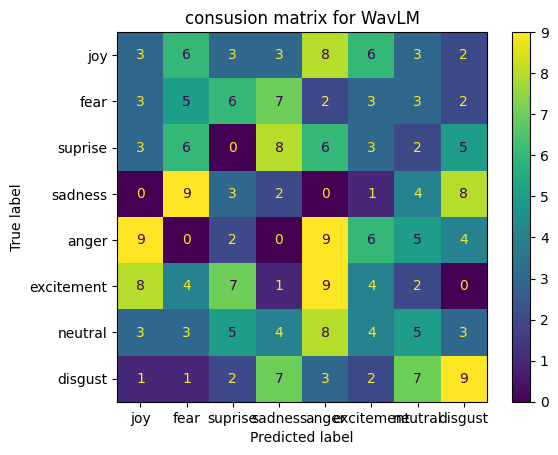

              precision    recall  f1-score   support

       anger       0.20      0.26      0.23        35
     disgust       0.27      0.28      0.28        32
  excitement       0.14      0.11      0.12        35
        fear       0.15      0.16      0.15        31
         joy       0.10      0.09      0.09        34
     neutral       0.16      0.14      0.15        35
     sadness       0.06      0.07      0.07        27
     suprise       0.00      0.00      0.00        33

    accuracy                           0.14       262
   macro avg       0.14      0.14      0.14       262
weighted avg       0.14      0.14      0.14       262



Text(0.5, 1.0, 't-SNE of WavLM features')

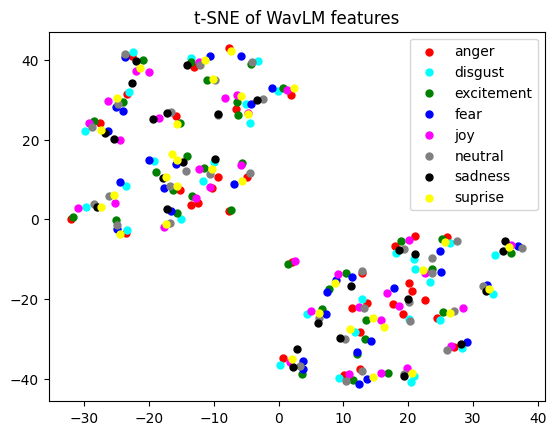

In [7]:
scaler = StandardScaler()
scaler.fit(embeddings_array)
X = scaler.transform(embeddings_array)
print(X.shape)

y = np.array(labels)
print(y.shape)

loo = LeaveOneOut()
loo.get_n_splits(X)

orig = []
pred = []

for i, (train_index, test_index) in enumerate(loo.split(X)):

    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    clf = svm.SVC(kernel = 'linear', C=1, probability=(False))
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)[0]

    orig.append(y_test[0])
    pred.append(y_pred)
cm = metrics.confusion_matrix(orig, pred, labels=list(set(labels)))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(labels)))
disp.plot()
plt.title('consusion matrix for WavLM')
plt.show()
print(metrics.classification_report(orig, pred))
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X)

cdict = {
    "sadness": 'black',
    "anger": 'red',
    "fear": 'blue',
    "excitement": 'green',
    "disgust": 'cyan',
    "suprise": 'yellow',
    "joy": 'magenta',
    "neutral": 'gray'
}

for g in np.unique(y):
    ix = np.where(y == g)
    plt.scatter(X_embedded[ix,0], X_embedded[ix,1], c = cdict[g], label = g, s = 25)
plt.legend()
plt.axis('on')
plt.title('t-SNE of WavLM features')